In [1]:
%load_ext autotime

time: 216 µs (started: 2022-07-07 13:47:01 +08:00)


In [115]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm.auto import tqdm

time: 1.64 ms (started: 2022-07-07 14:25:31 +08:00)


In [3]:
from matplotlib.backends.backend_pdf import PdfPages

time: 68.4 ms (started: 2022-07-07 13:47:02 +08:00)


In [4]:
pd.set_option('display.max_rows', 200, 'display.max_columns', None)

time: 186 µs (started: 2022-07-07 13:47:02 +08:00)


In [5]:
all_rows = pd.option_context("display.max_rows", None)

time: 152 µs (started: 2022-07-07 13:47:02 +08:00)


In [6]:
months = pd.Series({m: i for i, m in enumerate("FGHJKMNQUVXZ")})

time: 702 µs (started: 2022-07-07 13:47:02 +08:00)


In [7]:
dailies = pd.read_parquet("csi_data.parquet").rename(columns={"symbol": "contract"})
dailies.close *= dailies.mult
dailies.volume /= dailies.mult
dailies.open_interest /= dailies.mult

time: 7.1 s (started: 2022-07-07 13:47:02 +08:00)


In [8]:
prev_close = dailies.sort_values("date").groupby(["contract", "expiry"]).close.shift()
dailies["d_close"] = dailies.close - prev_close

time: 14.9 s (started: 2022-07-07 13:47:09 +08:00)


In [9]:
dailies["expiry_int"] = (
    dailies["expiry"].str.slice(0, 4).astype(int) * 12 + 
    dailies["expiry"].str.slice(4, 5).map(months)
)

time: 16.6 s (started: 2022-07-07 13:47:24 +08:00)


In [10]:
dailies["mod_month"] = dailies.eval(
    "expiry_int - (date.dt.year + (expiry_int.mod(12) < date.dt.month.sub(1))) * 12"
)

time: 2.36 s (started: 2022-07-07 13:47:41 +08:00)


In [11]:
dailies[["expiry_int", "mod_month"]] = dailies[["expiry_int", "mod_month"]].astype("Int64")

time: 8.59 s (started: 2022-07-07 13:47:43 +08:00)


In [12]:
dailies = dailies.query("mod_month.between(0, 11)").copy()

time: 4.26 s (started: 2022-07-07 13:47:52 +08:00)


In [13]:
dailies["mod_month"] = pd.Categorical.from_codes(dailies["mod_month"], months.index)

time: 42.1 ms (started: 2022-07-07 13:47:56 +08:00)


In [14]:
metadata = (
    pd.read_csv("contracts.csv")
    .dropna(subset=["Exch Symbol", "Currency", "Name", "Point Value", 
                    "Symbol", 'Futures Category'])
    .loc[lambda df: ~df.Symbol.isin(["TW1", "TW2"])]
    .rename(columns={"Symbol": "contract"})
    .set_index("contract")
)

metadata.loc[lambda df: df["Futures Category"].isin([
    'Indexes-Asian', 'Indexes-Australian',
    'Indexes-Canadian', 'Indexes-European',
    'Indexes-Global', 'Indexes-Indian Stocks',
    'Indexes-Mexican', 'Indexes-S. African', 'Indexes-S. American',
    'Indexes-U.S.',
]), 'Futures Category'] = "Equity Index"

metadata.loc[
    lambda df: df["Futures Category"].isin([
        'Govt Notes', 'Govt Bonds', 'Govt Rates', 'Interest Rates', 'Indexes-U.S. Bonds',
]), 'Futures Category'] = "Fixed Income"

metadata.loc["DX2", 'Futures Category'] = "FOREX"

time: 23.9 ms (started: 2022-07-07 13:47:56 +08:00)


In [15]:
names = metadata["Name"].str.lower()
point_values = metadata["Point Value"].str.lower()

time: 2.76 ms (started: 2022-07-07 13:47:56 +08:00)


In [16]:
multiplier = (
    point_values
    .loc[
        lambda df: (
            df.str.match("(usd|eur|\$|\d)")
            |
            df.str.contains("us dollar")
        )
    ]
    .str.extract("(\d+(?:[.]\d*)?|[.]\d+)", expand=False).astype(float)
    .mul(metadata["MinTick"])
    .rename("multiplier")
)
metadata["multiplier"] = multiplier

time: 5.82 ms (started: 2022-07-07 13:47:56 +08:00)


In [265]:
contract_mask = (
    metadata.Currency.isin(["USD", "EUR"])
    &
    metadata["Close Field Type"].eq("Settlement")
    &
    ~point_values.str.contains("contract")
    &
    ~point_values.str.contains("mwh")    
    &
    ~names.index.isin(["TF", "ER2", "SP2", "ZI", "ZN", "TU2", "LC1", "EX", "JT"])
#     &
#     # Too big
#     ~names.index.isin(["PA2", "LGO", "US"])
    &
    (
        names.str.contains("combined session")
        |
        ~names.str.contains("session")
    )
    &
    ~names.str.contains("divided by 10")
)

time: 15.2 ms (started: 2022-07-07 21:32:12 +08:00)


In [266]:
dailies = dailies.loc[lambda df: df.contract.map(contract_mask).fillna(False)]

time: 1.01 s (started: 2022-07-07 21:32:12 +08:00)


In [267]:
contract_volumes = (
    dailies
    .assign(decade=lambda df: df.eval("date.dt.year.floordiv(10).mul(10)"))
    .assign(adr=lambda df: df.eval("high - low"))
    .groupby(["contract", "decade"])
    .agg({"volume": "mean", "adr": "mean"})
    .reset_index()
)

time: 1.66 s (started: 2022-07-07 21:32:13 +08:00)


In [268]:
contract_volumes["multiplier"] = contract_volumes.contract.map(metadata.multiplier)
contract_volumes["currency"] = contract_volumes.contract.map(metadata.Currency)
contract_volumes["category"] = contract_volumes.contract.map(metadata['Futures Category'])
contract_volumes["exchange"] = contract_volumes.contract.map(metadata.Exchange)
contract_volumes["exch_symbol"] = contract_volumes.contract.map(metadata['Exch Symbol'])
contract_volumes["name"] = contract_volumes.contract.map(metadata['Name'])
contract_volumes["dollar_vol_per"] = contract_volumes.eval("adr * multiplier")
contract_volumes["dollar_vol"] = contract_volumes.eval("dollar_vol_per * volume")
contract_volumes["start_year"] = contract_volumes.contract.map(
    dailies.groupby("contract").date.min().dt.year.astype("Int64")
)

time: 191 ms (started: 2022-07-07 21:32:14 +08:00)


In [331]:
shortlist = (
    contract_volumes    
    .query("category != 'Equity Index'")
#     .query("category != 'Fixed Income'")
    .query("start_year < 2000 & decade == 2010")
    .query("contract not in ['CU', 'KC2']")
    .assign(cat_rank=lambda df: (
        df.groupby(["category", "decade"])
        .dollar_vol.rank(ascending=False)
        .fillna(0).astype(int)
    ))
    .sort_values(["cat_rank", "dollar_vol"], ascending=[True, False])
#     .loc[lambda df: df.dollar_vol_per.lt(1e4)]
    .head(30)
#     .sort_values("dollar_vol_per")
    [["dollar_vol", "dollar_vol_per", "currency", "contract", "exchange", "exch_symbol",
      "category", "cat_rank", "name", "start_year"]]
    .reset_index(drop=True)
)
with all_rows:
    display(
        shortlist
        .style
        .format(subset=["dollar_vol", "dollar_vol_per"], formatter="{:.1e}")
        .set_properties(subset=["name"], **{'white-space': 'pre-wrap'})
    )

,dollar_vol,dollar_vol_per,currency,contract,exchange,exch_symbol,category,cat_rank,name,start_year
0,2.9e+08,1.3e+03,USD,FV,CBT,FV,Fixed Income,1,5-Year U.S. T-Note (combined)-CBT,1988
1,1.3e+08,3.5e+03,USD,JY,CME,JY,FOREX,1,Japanese Yen (combined)-CME,1976
2,1.2e+08,1.6e+03,USD,CL2,NYMEX,CL,Energy,1,Crude Oil (combined)-NYMEX,1983
3,9.3e+07,6.1e+03,USD,HG2,COMEX,HG,Metals,1,Copper (combined)-COMEX,1976
4,9.0e+07,2.3e+03,USD,S2,CBT,S,Grains & Oilseeds,1,Soybeans (combined)-CBT,1976
5,1.6e+07,5.0e+02,USD,SB2,ICE-US,SB,Food & Fiber,1,Sugar #11 (combined),1976
6,1.3e+07,1.4e+03,USD,LC,CME,L2,Livestock & Meats,1,Live Cattle (combined)-CME,1976
7,2.4e+08,1.4e+03,EUR,EBM,EUREX,FGBM,Fixed Income,2,Euro German Bobl-EUREX,1991
8,9.6e+07,1.5e+03,USD,LCO,ICE-EU,B,Energy,2,Brent Crude (Combined)-(IPE),1988
9,8.8e+07,1.2e+03,USD,C2,CBT,C,Grains & Oilseeds,2,Corn (combined)-CBT,1976


time: 32.7 ms (started: 2022-07-08 07:51:43 +08:00)


In [332]:
top_ratio = (
    dailies
    .query("date > '2008'")
    .sort_values("volume")
    .groupby(["contract", "date"]).last()
    .groupby(["contract", "mod_month"]).volume.count()
)
top_ratio /= top_ratio.groupby("contract").transform("max")

time: 18 s (started: 2022-07-08 07:51:44 +08:00)


In [333]:
with PdfPages('expiry_volumes.pdf') as pdf:
    for contract_rank in tqdm(shortlist.index):

        title = "{contract_rank} - {contract} / {exch_symbol}({exchange}) / {name}".format(
            contract_rank=contract_rank, **shortlist.loc[contract_rank].to_dict()
        )

        plt.figure(dpi=100)

        ax = (
            top_ratio
            .loc[shortlist.contract[contract_rank]]
            .plot.bar(figsize=(8, 5), title=title)
        )
        
        ax.axhline(y=1/12, color="red")
        
        pdf.savefig()
        plt.close()        

  0%|          | 0/30 [00:00<?, ?it/s]

time: 1.22 s (started: 2022-07-08 07:52:02 +08:00)


In [334]:
active_months = top_ratio[top_ratio > 1/12].reset_index().drop("volume", axis=1)
dailies = dailies.merge(active_months)

time: 636 ms (started: 2022-07-08 07:52:03 +08:00)


In [335]:
volumes = dailies.set_index(["contract", "date", "expiry"]).volume.loc[lambda xs: xs > 0]
volumes /= volumes.groupby(["contract", "date"]).transform("sum")
volumes = volumes.sort_index().rename("volume_fraction")
volumes = volumes.groupby(["contract", "expiry"]).shift()

time: 1.93 s (started: 2022-07-08 07:52:03 +08:00)


In [336]:
front = (
    volumes
    .loc[lambda df: df.groupby(["contract", "expiry"]).cummax().gt(1/3)]
    .reset_index()
    .sort_values("expiry")
    .groupby(["contract", "date"])
    .first().set_index("expiry", append=True)
    .join(dailies.set_index(["contract", "date", "expiry"]))
    .reset_index("expiry")
)

time: 4.56 s (started: 2022-07-08 07:52:05 +08:00)


In [337]:
front["vol"] = (
    front
    .d_close.abs()
    .groupby("contract").rolling(180).mean()
    .reset_index(level=0, drop=True)
    .groupby("contract").shift()
)

time: 169 ms (started: 2022-07-08 07:52:10 +08:00)


In [338]:
with PdfPages('prices.pdf') as pdf:
    for contract in tqdm(shortlist.itertuples(), total=len(shortlist)):
        title = (f"{contract.Index} - {contract.contract} / "
                 f"{contract.exch_symbol}({contract.exchange}) / {contract.name}")
        plt.figure(dpi=100)

        (
            front.loc[contract.contract]
            .eval("d_close / vol").cumsum()
            .plot(figsize=(8, 5), title=title)
        )
        
        pdf.savefig()
        plt.close()        

  0%|          | 0/30 [00:00<?, ?it/s]

time: 2.22 s (started: 2022-07-08 07:52:10 +08:00)


In [339]:
signals = []
for ndays in [200]:
    signals.append(
        front
        .eval("d_close / vol")
        .groupby("contract").cumsum()
        .pipe(lambda xs: (
            xs.groupby("contract").rolling(ndays).mean().reset_index(level=0, drop=True)
            .lt(xs)
        ))
        .groupby("contract").shift(fill_value=False)
        .pipe(lambda xs: xs * 2 - 1)
        .groupby("contract").rolling(30).mean().reset_index(level=0, drop=True)
    )
signal = pd.concat(signals, axis=1).mean(axis=1)

time: 356 ms (started: 2022-07-08 07:52:12 +08:00)


In [340]:
start_year = "1980"

rets = front.eval("d_close / vol * @signal")
pnl = rets.loc[shortlist.contract].groupby("date").sum()[start_year:]
bnh_rets = front.eval("d_close / vol")
leverage = 0.005
risk = leverage / pnl.std()

time: 204 ms (started: 2022-07-08 07:52:13 +08:00)


In [341]:
def plot_dd(c_pl, title):
    xlim=(c_pl.index[0], c_pl.index[-1])
    c_pl.plot(lw=1, color="black", title=title, xlim=xlim)
    plt.ylabel("Cumulative vol-normalized points")
    plt.fill_between(c_pl.index, c_pl, c_pl.cummax(), facecolor='red', alpha=0.5);
    

time: 327 µs (started: 2022-07-08 07:52:13 +08:00)


In [342]:
with PdfPages('returns.pdf') as pdf:
    c_pl = pnl.mul(risk).cumsum()
    plt.figure(figsize=(8, 5), dpi=100)
    plot_dd(c_pl, title="Trend")
    
    ax = (
        front.loc[shortlist.contract]
        .groupby("date").expiry.count()
        .cummax()
        .plot(secondary_y=True)
    )
    ax.set_ylabel("Contract Count", rotation=-90, labelpad=20)
    ax.set_ylim(0, None)

    pdf.savefig()
    plt.close("all")
    
    c_bnh = (
        bnh_rets.loc[shortlist.contract]
        .groupby("date").sum()
        [start_year:].mul(risk).cumsum()
    )
    plt.figure(figsize=(8, 5), dpi=100)
    plot_dd(c_bnh, title="Buy and Hold")

    pdf.savefig()
    plt.close("all")
    
    for contract in tqdm(shortlist.itertuples(), total=len(shortlist)):
        title = (f"{contract.Index} - {contract.contract} / "
                 f"{contract.exch_symbol}({contract.exchange}) / {contract.name}")
        
        all_rets = pd.DataFrame({
            "trend": rets.loc[contract.contract],
            "buy and hold": bnh_rets.loc[contract.contract],
        })
        
        plt.figure(dpi=100)
        
        ax = signal.loc[contract.contract].plot(secondary_y=True, color="grey", alpha=0.3)
        ax.set_ylabel("Signal", rotation=-90)
#         ax.set_ylim(-0.2, 1.3)
        
        ax = (
            all_rets.loc[start_year:].cumsum()
            .plot(
                figsize=(8, 5), 
                title=title,
                xlim=(pnl.index[0], pnl.index[-1]),
                ax=ax,
            )
        )
        ax.left_ax.set_ylabel("Cumulative vol-normalized points")
        ax.legend(*ax.left_ax.get_legend_handles_labels(), loc="upper left")
                
        pdf.savefig()
        plt.close("all")

  0%|          | 0/30 [00:00<?, ?it/s]

time: 3.87 s (started: 2022-07-08 07:52:13 +08:00)


In [343]:
all_rets_by_category = (
    pd.DataFrame({
        "trend": rets,
        "buy and hold": bnh_rets,
    })
    .loc[shortlist.contract]
)
all_rets_by_category = (
    all_rets_by_category
    .groupby([
        all_rets_by_category.index.get_level_values("contract").map(metadata["Futures Category"]).rename("category"),
        "date"
    ]).sum()
)

time: 150 ms (started: 2022-07-08 07:52:17 +08:00)


In [344]:
with PdfPages('returns_by_category.pdf') as pdf:
    for category in tqdm(all_rets_by_category.index.get_level_values("category").drop_duplicates()):
        plt.figure(figsize=(8, 5), dpi=100)
        plot_dd(all_rets_by_category.loc[category]["trend"].loc[start_year:].cumsum(), 
                title=f"{category} trend")
        pdf.savefig()
        plt.close("all")
        
        plt.figure(figsize=(8, 5), dpi=100)
        plot_dd(all_rets_by_category.loc[category]["buy and hold"].loc[start_year:].cumsum(), 
                title=f"{category} buy and hold")
        pdf.savefig()
        plt.close("all")

  0%|          | 0/7 [00:00<?, ?it/s]

time: 1.87 s (started: 2022-07-08 07:52:17 +08:00)


In [345]:
decade = (pnl.index.get_level_values("date").year // 5) * 5
by_period = {}
legend = []
for _, pnl0 in pnl.groupby(decade):
    yr0 = pnl0.index.year[0]
    pnl0.index = ((pnl0.index - pd.Timestamp(yr0, 1, 1)) / pd.Timedelta(days=1)).astype(int)
    by_period[yr0] = pnl0
by_period = pd.DataFrame(by_period)

time: 7.18 ms (started: 2022-07-08 07:52:19 +08:00)


<AxesSubplot:xlabel='date'>

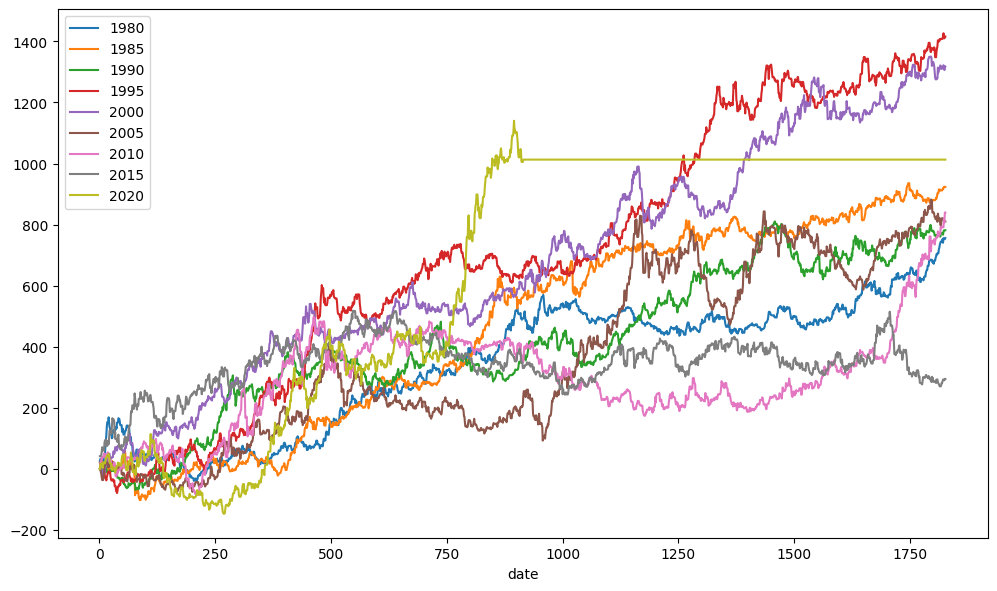

time: 142 ms (started: 2022-07-08 07:52:19 +08:00)


In [346]:
plt.figure(figsize=(12, 7), dpi=100)
by_period.cumsum().fillna(method="ffill").plot(ax=plt.gca())

In [347]:
by_period.apply(lambda xs: xs.mean() / xs.std() * 250**0.5)

1980    1.160354
1985    1.267948
1990    1.014778
1995    1.563237
2000    1.400378
2005    0.738263
2010    0.837102
2015    0.316480
2020    1.595839
dtype: float64

time: 3.8 ms (started: 2022-07-08 07:52:19 +08:00)


In [348]:
ES_signal = (
    front.loc["ES"].eval("d_close / vol").cumsum()
    .pipe(lambda xs: xs.rolling(200).mean().lt(xs))
    .shift(fill_value=False)
    .rolling(90).mean()
)

ES_position = (
    ES_signal
    .div(front.vol["ES"])
    .div(metadata.multiplier["ES"])
)

ES_ret = ES_position.mul(front.d_close["ES"])

ES_risk = leverage / ES_ret.std()

time: 7.5 ms (started: 2022-07-08 07:52:19 +08:00)


In [349]:
(
    pd.concat([
        ES_ret.rename("ES"), 
        pnl.rename("Portfolio"),
    ], axis=1)
    .dropna()
    .groupby(pd.Grouper(freq="5Y"))
    .corr()
    .unstack().iloc[:, 1]
    .rename(lambda xs: xs.year)
)

date
1983   -0.049149
1988    0.004427
1993   -0.044578
1998   -0.042873
2003   -0.067221
2008    0.024170
2013    0.105221
2018   -0.001537
2023   -0.061895
Name: (ES, Portfolio), dtype: float64

time: 10.7 ms (started: 2022-07-08 07:52:19 +08:00)


<AxesSubplot:title={'center':'Gross Sharpe'}, xlabel='date'>

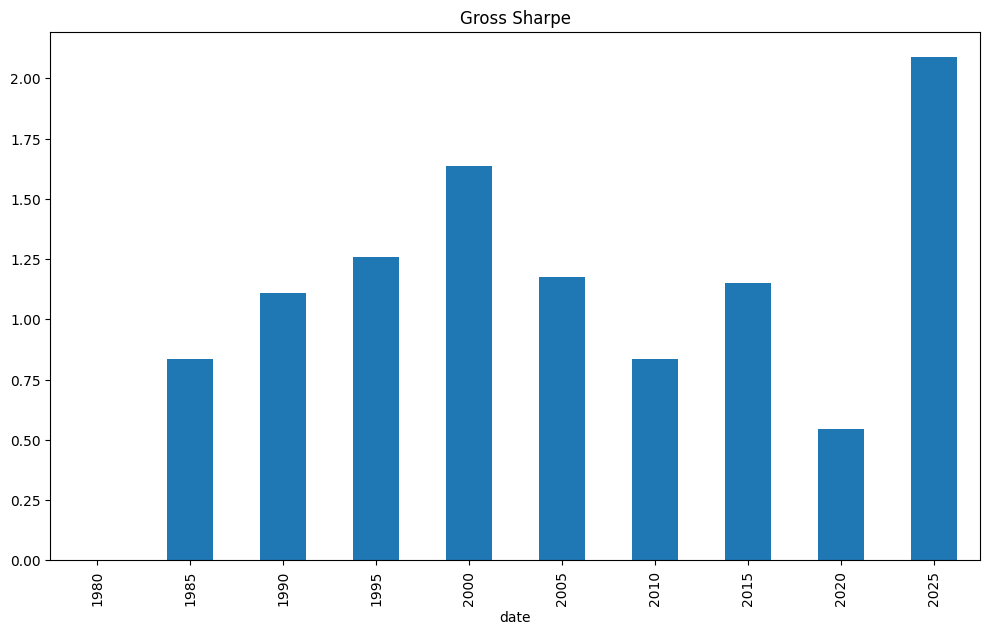

time: 87.7 ms (started: 2022-07-08 07:52:19 +08:00)


In [350]:
plt.figure(figsize=(12, 7), dpi=100)
(
    (ES_ret.mul(ES_risk) + pnl.mul(risk))
    .groupby(pd.Grouper(freq="5Y"))
    .apply(lambda xs: xs.mean() / xs.std() * 250**0.5)
    .rename(lambda xs: xs.year)    
    .plot.bar(title="Gross Sharpe")
)

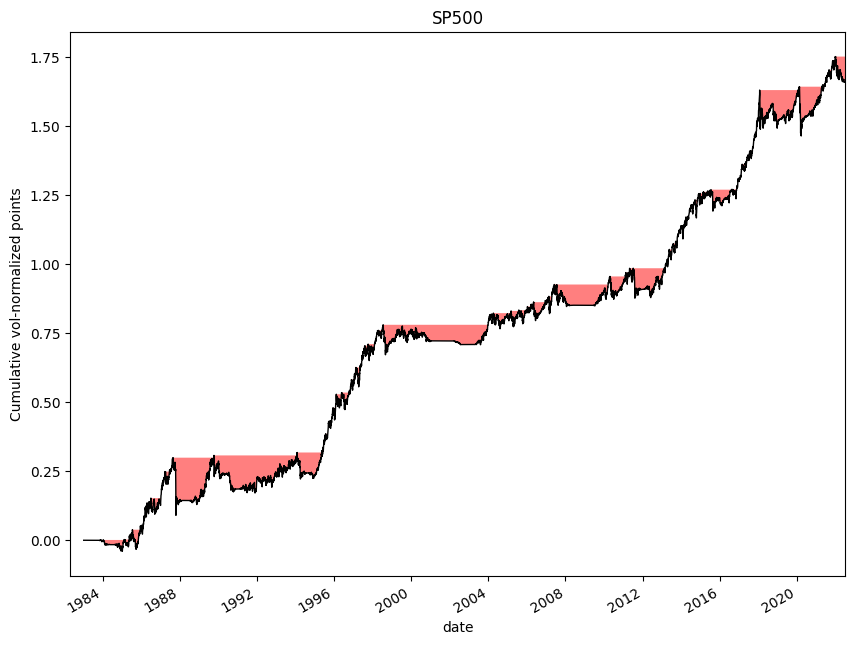

time: 142 ms (started: 2022-07-08 07:52:19 +08:00)


In [351]:
plt.figure(figsize=(10, 8), dpi=100)
plot_dd(ES_ret.mul(ES_risk).cumsum(), "SP500")

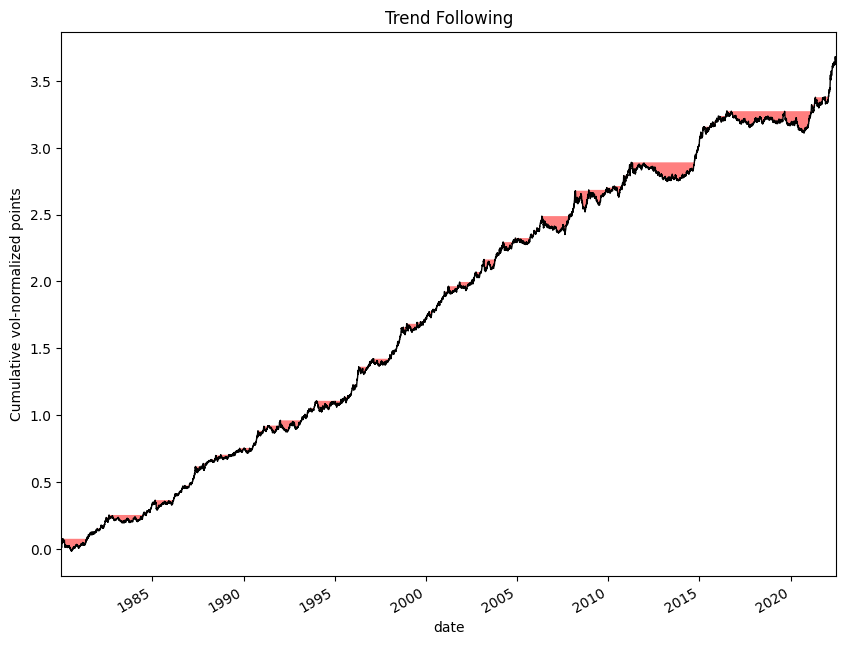

time: 132 ms (started: 2022-07-08 07:52:19 +08:00)


In [352]:
plt.figure(figsize=(10, 8), dpi=100)
plot_dd(pnl.mul(risk).cumsum(), "Trend Following")

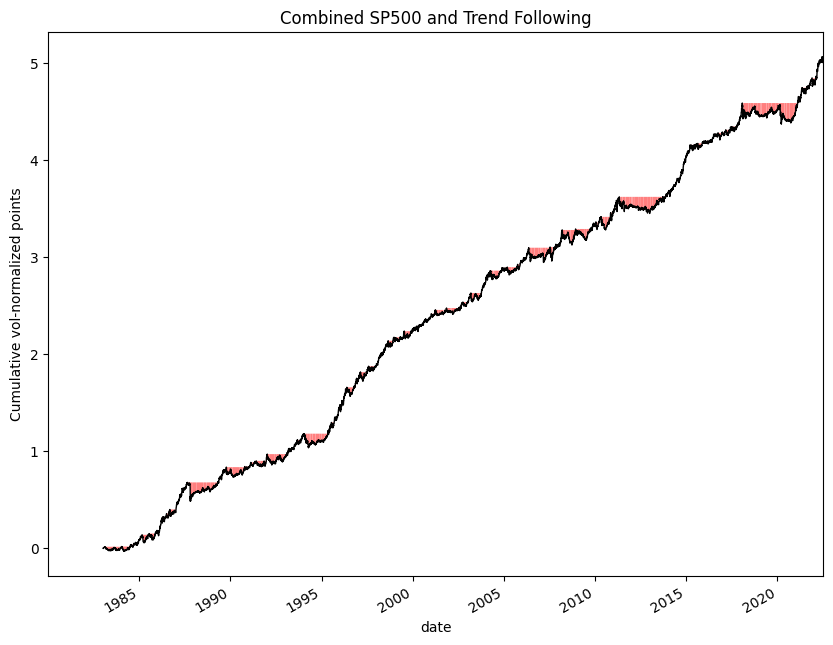

time: 147 ms (started: 2022-07-08 07:52:19 +08:00)


In [353]:
plt.figure(figsize=(10, 8), dpi=100)
plot_dd((ES_ret.mul(ES_risk) + pnl.mul(risk)).cumsum(), "Combined SP500 and Trend Following")

In [354]:
# index from https://www.iasg.com/en/indexes/trend-following-index/historical-data
iasg_index = (
    pd.read_html("tf_index.html")[0].set_index("Year")
    .rename_axis(columns="Month").drop(["YTD", "DD"], axis=1)
    .stack("Month").rename("return").reset_index()
    .assign(ts=lambda df: pd.to_datetime(
        df["Year"].astype(str) + df["Month"], format="%Y%b"
    ))
    .set_index("ts")["return"]
    .sort_index()
    .transform(lambda xs: xs / xs.abs().rolling(12).mean())
)


comparison = pd.concat([
    iasg_index.dropna().groupby(pd.Grouper(freq="M")).sum()[1:].rename("index"),
    pnl.groupby(pd.Grouper(freq="M")).sum()[1:].rename("ours")
], axis=1).dropna()

(
    comparison
    .groupby(lambda xs: (xs.year // 10) * 10)
    .corr().unstack().iloc[:, 1]
)

1980    0.511161
1990    0.547463
2000    0.653802
2010    0.656677
2020    0.695505
Name: (index, ours), dtype: float64

time: 35.8 ms (started: 2022-07-08 07:52:20 +08:00)


<AxesSubplot:title={'center':'ES returns'}, xlabel='date'>

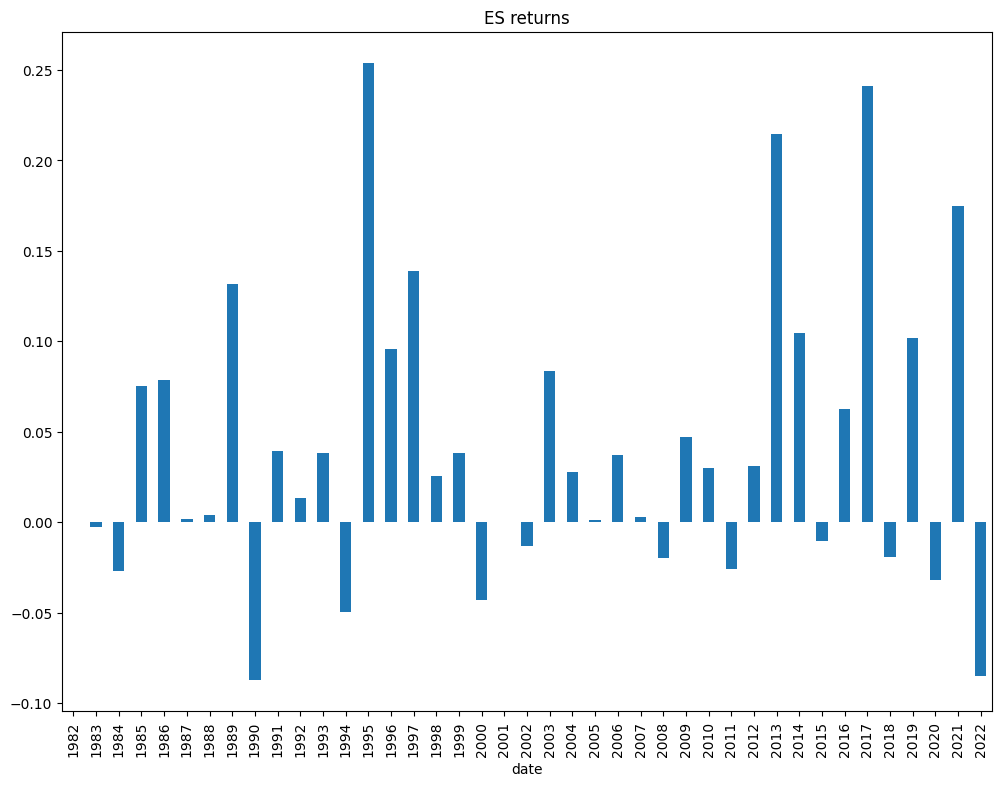

time: 185 ms (started: 2022-07-08 07:52:20 +08:00)


In [355]:
plt.figure(figsize=(12, 9), dpi=100)
(
    ES_ret.mul(ES_risk).add(1)
    .groupby(pd.Grouper(freq="Y")).prod().sub(1)
    .rename(lambda xs: xs.year)
#     .pipe(lambda xs: np.exp(np.log(xs + 1).mean()) - 1)
    .plot.bar(title="ES returns")
)

<AxesSubplot:title={'center':'TF returns'}, xlabel='date'>

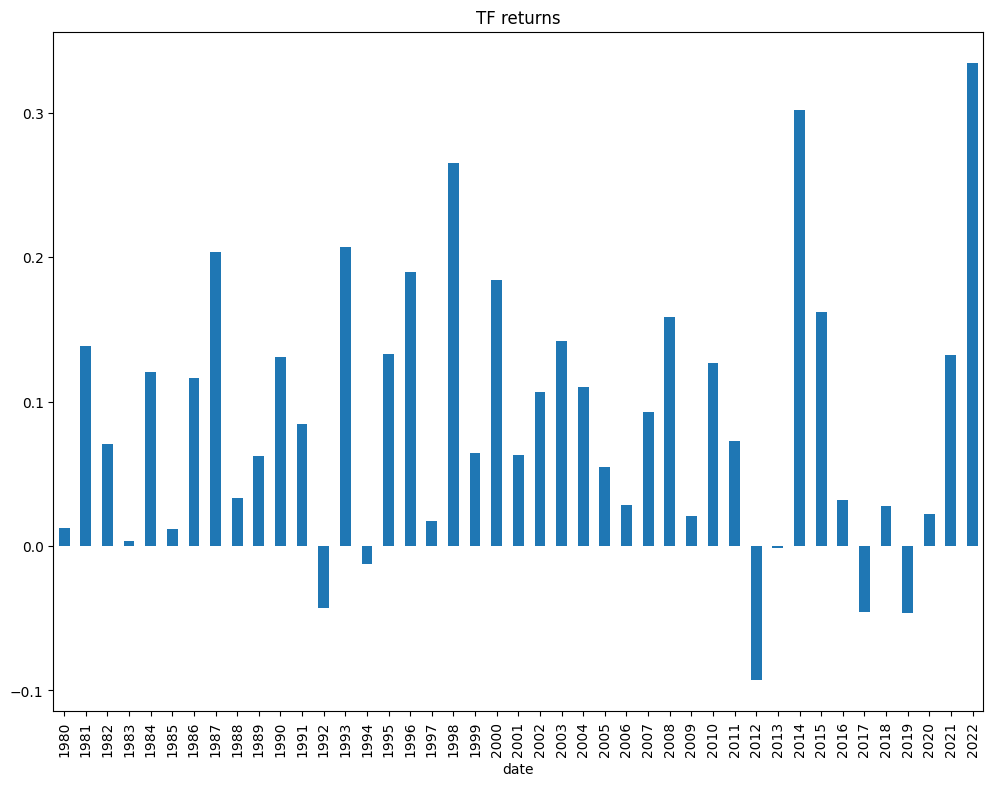

time: 177 ms (started: 2022-07-08 07:52:20 +08:00)


In [356]:
plt.figure(figsize=(12, 9), dpi=100)
(
    pnl
    .mul(risk).add(1)
    .groupby(pd.Grouper(freq="Y")).prod().sub(1)
    .rename(lambda xs: xs.year)
#     .pipe(lambda xs: np.exp(np.log(xs + 1).mean()) - 1)
    .plot.bar(title="TF returns")
)

<AxesSubplot:title={'center':'Total returns'}, xlabel='date'>

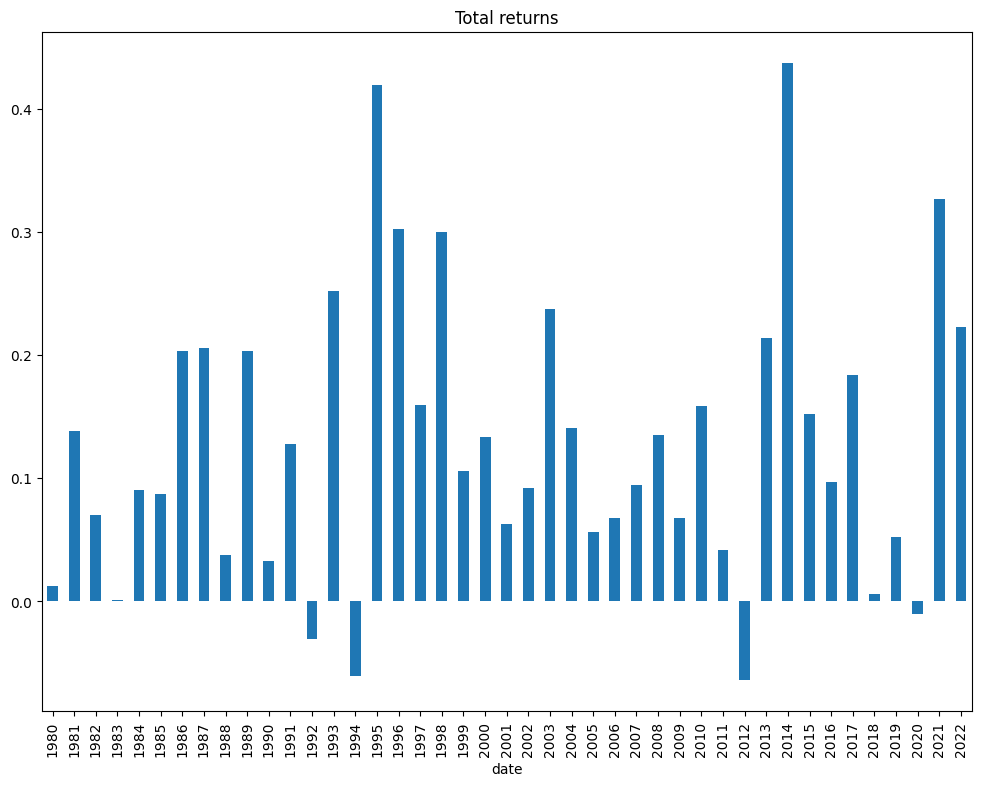

time: 176 ms (started: 2022-07-08 07:52:20 +08:00)


In [357]:
plt.figure(figsize=(12, 9), dpi=100)
(
    ES_ret.mul(ES_risk).add(pnl.mul(risk), fill_value=0).add(1)
    .groupby(pd.Grouper(freq="Y")).prod().sub(1)
    .rename(lambda xs: xs.year)
#     .pipe(lambda xs: np.exp(np.log(xs + 1).mean()) - 1)
    .plot.bar(title="Total returns")
)

<AxesSubplot:title={'center':'Drawdowns'}, xlabel='date'>

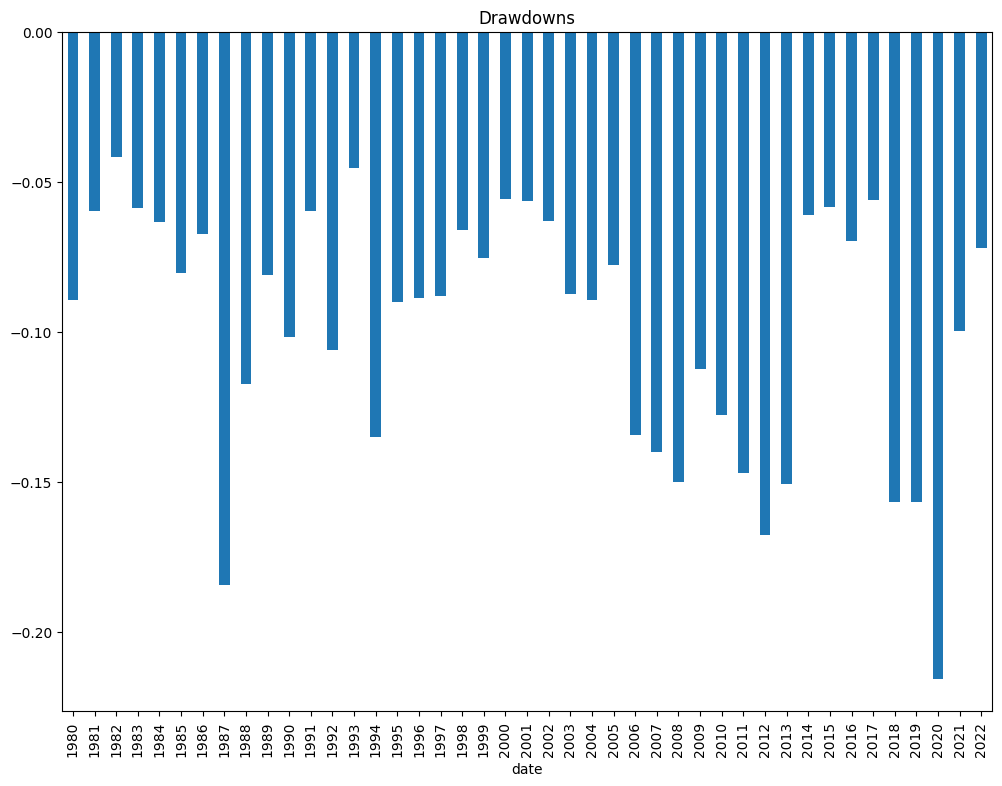

time: 171 ms (started: 2022-07-08 07:52:20 +08:00)


In [358]:
plt.figure(figsize=(12, 9), dpi=100)
(
    ES_ret.mul(ES_risk).add(pnl.mul(risk), fill_value=0)
    .add(1).cumprod()
    .pipe(lambda xs: xs.div(xs.cummax()) - 1)
    .groupby(pd.Grouper(freq="Y")).min()
    .rename(lambda xs: xs.year)
    .plot.bar(title="Drawdowns")
)

In [359]:
contracts_per_dollar =(
    signal.div(front.vol)
    .div(metadata.multiplier)
    .loc[shortlist.contract]
    .mul(risk).dropna()
)

time: 170 ms (started: 2022-07-08 07:52:20 +08:00)


In [384]:
balance = 2e6
actual_positions = contracts_per_dollar.mul(balance).round()

time: 25.4 ms (started: 2022-07-08 08:52:31 +08:00)


In [385]:
# with PdfPages('actual_positions.pdf') as pdf:
#     for date0, row in tqdm(
#         actual_positions.unstack("contract")
#         .fillna(method="ffill").dropna()
#         .sort_index()[start_year:]
#         .sample(10).sort_index().iterrows()
#     ):
#         plt.figure(figsize=(8, len(row) * 0.25))
#         row.rename(index=metadata.Name).plot.barh(title=str(date0.date()))
#         plt.tight_layout()
#         pdf.savefig()
#         plt.close("all")

time: 508 µs (started: 2022-07-08 08:52:31 +08:00)


In [386]:
actual_trades = (
    actual_positions
    .groupby(["contract", front.expiry]).diff()
    .fillna(actual_positions)
)
actual_trades_wo_rolls = (
    actual_positions
    .groupby(["contract"]).diff()
    .fillna(actual_positions)
)

time: 1.86 s (started: 2022-07-08 08:52:31 +08:00)


In [400]:
(
    actual_trades.loc[lambda xs: xs.ne(0)]
    .reorder_levels([1, 0])
    .sort_index().tail(20)
    .unstack("contract")
    .rename(lambda xs: xs.date())
    .style
    .format("{:.0f}", na_rep="")
)

contract,CD,LH,SI2,EBL,CC2,BP,DX2,ED,SB2,FV,GC2,TY,LC
date,,,,,,,,,,,,,
2022-06-02,1,,,,,,,,,,,,
2022-06-03,,-1,,,,,,,,,,,
2022-06-06,,,-1,,,,,,,,,,
2022-06-09,,,,-2,,,,,,,,,
2022-06-13,,,,,-1,,,,,,,,
2022-06-14,,,,,,-3,1,-8,-1,,,,
2022-06-15,,-1,,,,,,1,,1,-1,,
2022-06-16,,,,1,,,,,,,,,
2022-06-22,,,,,,,,,,,,-1,


time: 25.2 ms (started: 2022-07-08 08:53:31 +08:00)


In [388]:
contracts_traded = actual_trades.abs().groupby("date").sum()
contracts_traded_wo_rolls = actual_trades_wo_rolls.abs().groupby("date").sum()

time: 10.8 ms (started: 2022-07-08 08:52:33 +08:00)


In [389]:
actual_returns = (
    actual_positions
    .mul(front.d_close.loc[shortlist.contract])
    .mul(metadata.multiplier)
    .groupby("date").sum()
)

time: 1.71 s (started: 2022-07-08 08:52:33 +08:00)


<AxesSubplot:title={'center':'Dollars gross profit per contract roundtrip'}, xlabel='date'>

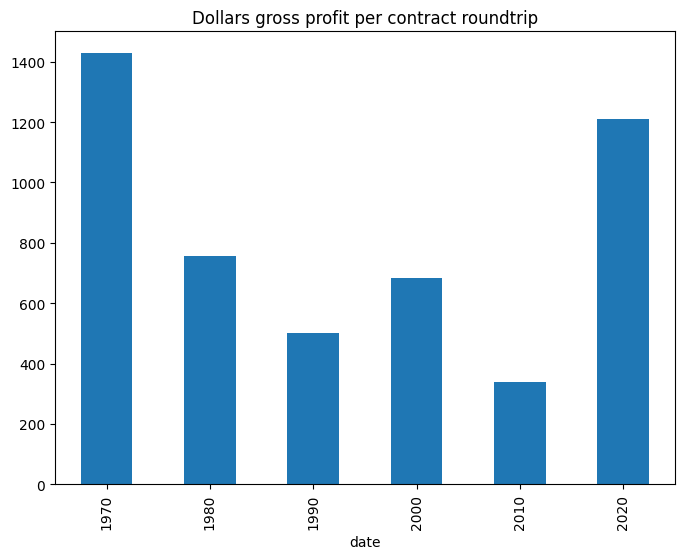

time: 76.3 ms (started: 2022-07-08 08:52:35 +08:00)


In [390]:
plt.figure(figsize=(8, 6), dpi=100)
(
    actual_returns.groupby(lambda xs: (xs.year // 10) * 10).sum()
    .div(contracts_traded.groupby(lambda xs: (xs.year // 10) * 10).sum().div(2))
    .plot.bar(title="Dollars gross profit per contract roundtrip")
)

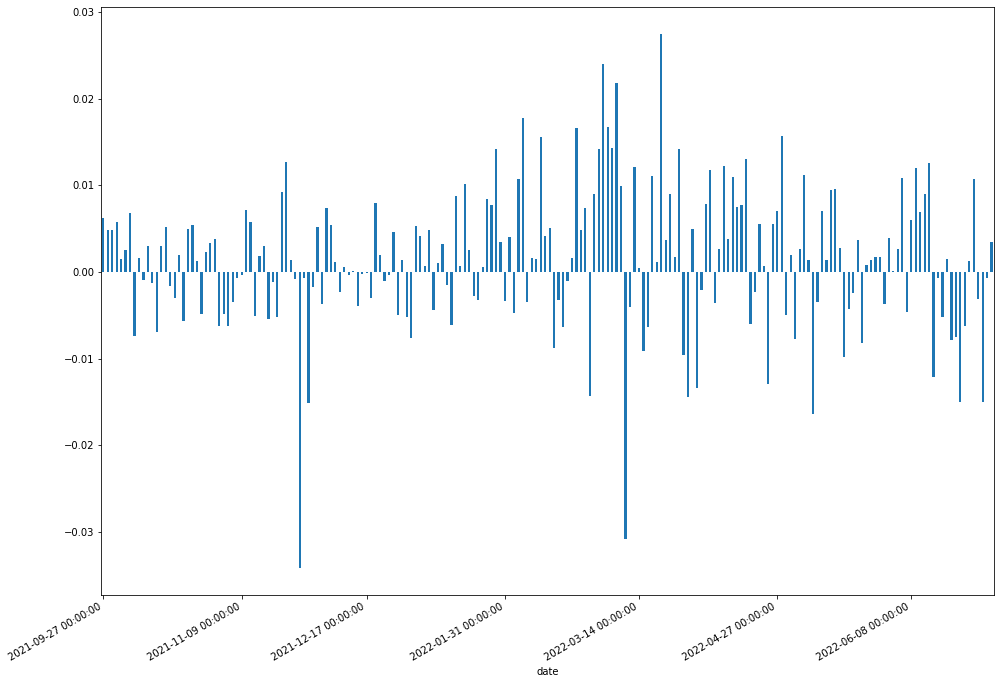

time: 343 ms (started: 2022-07-08 08:52:35 +08:00)


In [391]:
ax = pnl.mul(risk).tail(200).plot.bar(figsize=(16, 12))
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=1))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

<AxesSubplot:xlabel='date'>

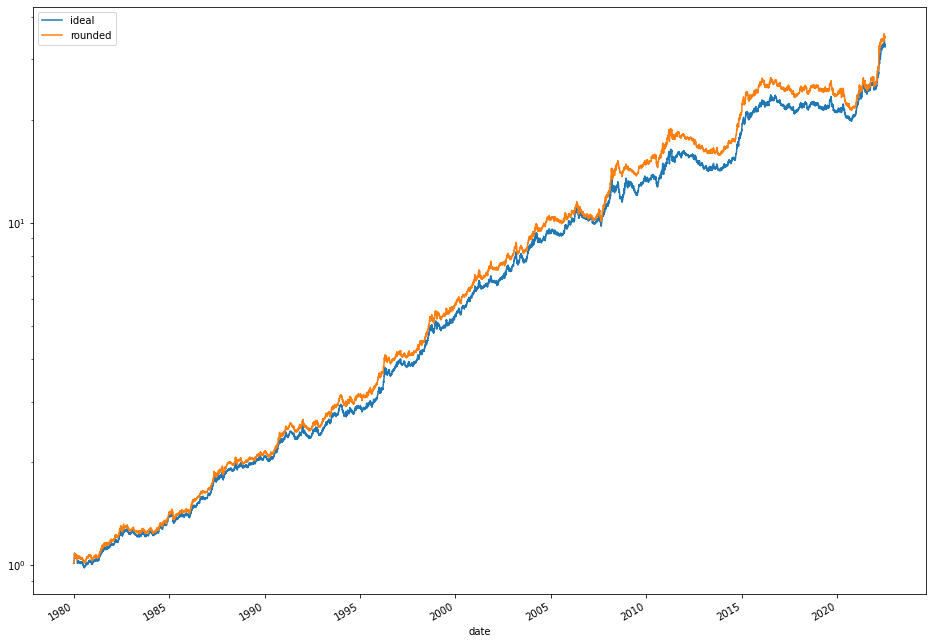

time: 219 ms (started: 2022-07-08 08:52:35 +08:00)


In [392]:
(
    pd.DataFrame({
        "ideal": pnl.mul(risk),
        "rounded": actual_returns.div(balance),
    })[start_year:]
    .add(1)
    .cumprod()
    .plot(logy=True, figsize=(16, 12))
)

<AxesSubplot:xlabel='date'>

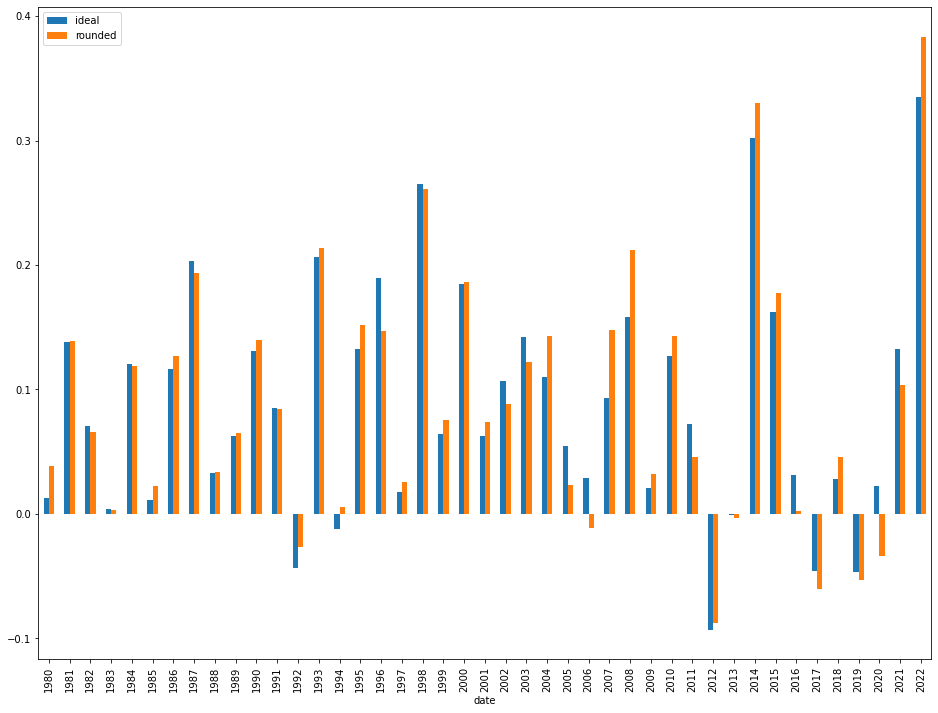

time: 252 ms (started: 2022-07-08 08:52:35 +08:00)


In [393]:
(    
    pd.DataFrame({
        "ideal": pnl.mul(risk),
        "rounded": actual_returns.div(balance),
    })
    [start_year:]
    .add(1).groupby(pd.Grouper(freq="Y")).prod().sub(1)
    .rename(lambda xs: xs.year)
    .plot.bar(figsize=(16, 12))
)

<AxesSubplot:xlabel='date'>

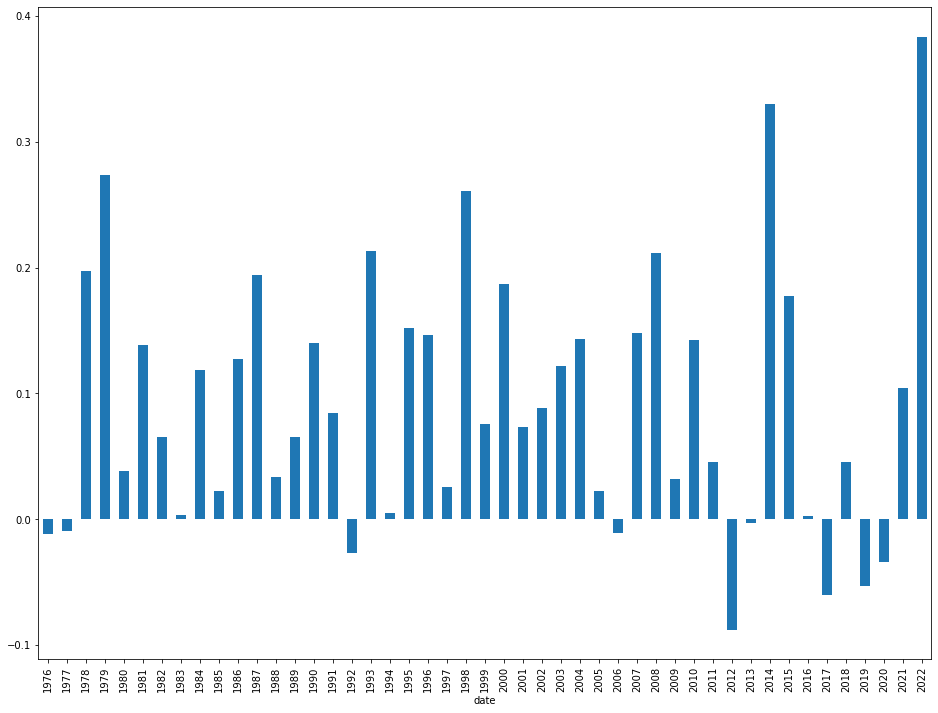

time: 199 ms (started: 2022-07-08 08:52:36 +08:00)


In [394]:
(
    actual_returns.div(balance).add(1)
    .groupby(pd.Grouper(freq="Y")).prod().sub(1)
    .rename(lambda xs: xs.year).plot.bar(figsize=(16, 12))
)